In [154]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pymongo import MongoClient
import requests

from tqdm import tqdm
from collections import Counter

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from keras.preprocessing.sequence import pad_sequences
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.callbacks import ProgbarLogger, Callback

In [42]:
db = MongoClient()['sheldon']
mongo = db.producthunt

In [12]:
resp = requests.get('https://api.producthunt.com/v1/posts?days_ago=1000',
                    headers={
                        'Authorization': 'Bearer XXX'
                    })

In [13]:
resp.json()

{'posts': [{'category_id': 1,
   'comments_count': 11,
   'created_at': '2014-07-20T06:21:49.549-07:00',
   'current_user': {'commented_on_post': False, 'voted_for_post': False},
   'day': '2014-07-20',
   'discussion_url': 'https://www.producthunt.com/posts/resumonk?utm_campaign=producthunt-api&utm_medium=api&utm_source=Application%3A+Sheldon+AI+%28ID%3A+4536%29',
   'exclusive': None,
   'featured': True,
   'id': 5579,
   'ios_featured_at': None,
   'maker_inside': False,
   'makers': [],
   'name': 'Resumonk',
   'platforms': [],
   'product_state': 'default',
   'redirect_url': 'https://www.producthunt.com/r/ba4a853b07/5579?app_id=4536',
   'screenshot_url': {'300px': 'http://beta.url2png.com/v6/P5329C1FA0ECB6/10f91363a23ba50a5867cba678687d9d/png/?max_width=300&url=https%3A%2F%2Fwww.resumonk.com',
    '850px': 'http://beta.url2png.com/v6/P5329C1FA0ECB6/544663636a062dad0c37c3ff8eb6dec4/png/?max_width=850&url=https%3A%2F%2Fwww.resumonk.com'},
   'tagline': 'Create a beautiful & stan

In [54]:
mongo.delete_many({})

In [55]:
posts = []
for i in tqdm(range(1, 1001)):
    resp = requests.get(
        'https://api.producthunt.com/v1/posts?days_ago={}'.format(i), 
         headers={'Authorization': 'Bearer XXX'}
    )
    documents = []
    for post in resp.json()['posts']:
        if post['category_id'] != 1:
            continue
        documents.append({'text': post['tagline'], '_id': post['id'], 'score': post['votes_count']})
    mongo.insert_many(documents)


100%|██████████| 1000/1000 [28:02<00:00,  1.73s/it]


In [56]:
mongo.find().count()

25455

In [40]:
len(posts)

11

In [77]:
scores = []
for item in tqdm(mongo.find()):
    scores.append((item['_id'], item['score'], item['text']))


0it [00:00, ?it/s]
102it [00:00, 372.42it/s]
25455it [00:00, 71672.64it/s]

In [79]:
list(sorted(scores, key=lambda x: x[1], reverse=True))

[(14717, 7822, 'A curated directory of 400 resources & tools for startups'),
 (22121, 5693, 'The best free stock photos in one place'),
 (75048, 4631, 'Real decks from real startups that raised over $400M'),
 (43665, 4580, 'A simple, beautiful, and powerful email client for Mac'),
 (84436, 4230, 'Amazon stores with no lines or checkout 🛍'),
 (57801, 4229, 'Email copy from great companies. '),
 (9917, 4165, 'Super fast color schemes generator for cool designers'),
 (66785, 3724, 'AI that turns your photos into artwork in seconds'),
 (57242, 3656, 'The mass market electric car by Tesla is here ⚡️🚘'),
 (25535, 3640, 'A\u200brticles you need to read before launching a startup.'),
 (52794, 3627, 'A new way to start an internet business anywhere'),
 (52932, 3624, 'Free (do whatever you want) high-res photos'),
 (83789, 3516, 'Watch Netflix anytime without an internet connection'),
 (62423, 3375, 'Google Search, GIFs, emojis & more—right from your keyboard'),
 (28256, 3317, 'A curated directo

/home/sheldonai/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


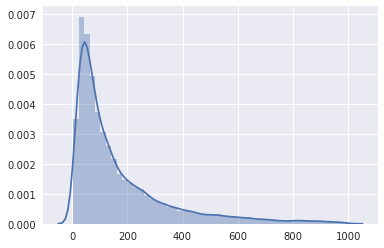

In [75]:
sns.distplot([x[1] for x in scores if x[1] < 1000])

In [121]:
scores_limit = 750
x_data, y_data = [], []
for item in mongo.find():
    x_data.append(item['text'].lower())
    y_data.append(min(item['score'], scores_limit))

## Char RNN

In [88]:
counter = Counter()
for text in x_data:
    for sym in text:
        counter[sym] += 1
print('Total vocab size:', len(counter))
i = 0
for sym, num in counter.most_common():
    if num >= 50:
        i += 1
print('Bigger than 50 occurances vocab:', i)
print(counter.most_common(56))

Total vocab size: 452
Bigger than 50 occurances vocab: 56
[(' ', 161616), ('e', 108088), ('o', 81783), ('t', 77169), ('a', 76157), ('r', 69511), ('i', 65870), ('s', 65836), ('n', 61543), ('l', 39376), ('c', 34598), ('d', 33587), ('u', 31074), ('p', 28649), ('h', 27132), ('m', 26788), ('f', 22816), ('y', 21886), ('g', 20363), ('w', 16281), ('b', 15538), ('v', 11236), ('k', 10228), ('.', 5008), (',', 4748), ('-', 3678), ('x', 2574), ('&', 1887), ('j', 1531), ("'", 1503), ('z', 1428), ('0', 1113), ('q', 837), (')', 824), ('(', 818), ('1', 684), ('!', 661), ('/', 570), ('2', 439), ('3', 411), ('+', 356), ('5', 342), ('’', 243), ('6', 242), ('"', 229), ('4', 226), ('9', 209), ('$', 165), ('8', 163), ('?', 162), (':', 124), ('7', 107), ('#', 63), ('%', 61), ('️', 60), ('…', 51)]


In [181]:
# Not implemented yet.

## Word RNN

In [94]:
stopwords_list = stopwords.words('english')

In [99]:
counter = Counter()
for text in x_data:
    for word in word_tokenize(text):
        if word not in stopwords_list:
            counter[word] += 1
print('Total vocab size:', len(counter))
i = 0
for sym, num in counter.most_common():
    if num >= 100:
        i += 1
print('Bigger than 100 occurances vocab:', i)
print(counter.most_common(i))

Total vocab size: 14635
Bigger than 100 occurances vocab: 236
[(',', 4690), ('.', 4654), ('&', 1887), ('app', 1396), ("'s", 1084), ('new', 843), (')', 824), ('(', 818), ('way', 785), ('create', 778), ('get', 700), ('share', 682), ('!', 661), ('free', 642), ('simple', 620), ('find', 616), ('best', 612), ('web', 535), ('world', 534), ('ios', 519), ('video', 487), ('friends', 481), ('mobile', 478), ('music', 473), ('one', 468), ('discover', 453), ('beautiful', 451), ('make', 434), ('people', 431), ('photos', 415), ('design', 410), ('iphone', 403), ('slack', 402), ('mac', 398), ('smart', 393), ('apps', 390), ('email', 387), ('videos', 383), ('social', 372), ('online', 359), ('time', 357), ('platform', 350), ('phone', 341), ('turn', 340), ('first', 336), ('tool', 324), ('easy', 314), ('build', 309), ('data', 308), ('watch', 308), ('live', 303), ('product', 298), ('every', 298), ('send', 296), ('news', 293), ('curated', 276), ('track', 276), ('text', 273), ('search', 270), ('content', 268), 

In [100]:
vocab_size = 236
vocab_list = [x[0] for x in counter.most_common(vocab_size)]

/home/sheldonai/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


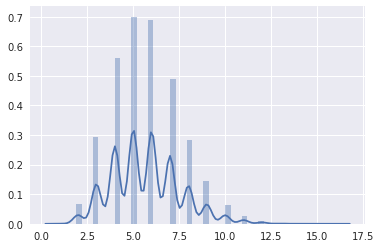

In [102]:
words_num = []
for text in x_data:
    i = 0
    for word in word_tokenize(text):
        if word not in stopwords_list:
            i += 1
    words_num.append(i)
sns.distplot(words_num)

In [103]:
seq_size = 10

In [140]:
X = []
vocab_set = set(vocab_list)
for text in tqdm(x_data):
    words = [y for y in word_tokenize(text) if y not in stopwords_list and y in vocab_set]
    record = []
    for word in words:
        for i, vword in enumerate(vocab_list):
            if vword == word:
                record.append(i)
                break
    X.append(record)

100%|██████████| 25455/25455 [00:03<00:00, 7100.77it/s]


In [141]:
X = pad_sequences(X, maxlen=seq_size)

In [125]:
Y = []
for y in y_data:
    Y.append(y / scores_limit)
Y = np.array(Y)

In [143]:
X

array([[  0,   0,   0, ...,  47, 151,   1],
       [  0,   0,   0, ...,   0,   0,  65],
       [  0,   0,   0, ...,   0,  57,  32],
       ..., 
       [  0,   0,   0, ..., 153,  30,   3],
       [  0,   0,   0, ...,   0,   0,   2],
       [  0,   0,   0, ...,   0,   0,  58]], dtype=int32)

In [161]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=seq_size))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 10, 32)            7552      
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 60,853.0
Trainable params: 60,853
Non-trainable params: 0.0
_________________________________________________________________
None


In [155]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.acc = []
        self.val_loss = []
        self.val_acc = []


    def on_epoch_end(self, batch, logs={}):
        print('Epoch end:', logs.get('loss'))
        self.loss.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))

In [162]:
history = model.fit(X, Y, epochs=200, verbose=0, callbacks=[LossHistory()],)

Epoch end: 0.547837799939 None
Epoch end: 0.541091463121 None
Epoch end: 0.53948377459 None
Epoch end: 0.539117233663 None
Epoch end: 0.538612742308 None
Epoch end: 0.538071029428 None
Epoch end: 0.537556219213 None
Epoch end: 0.537164285438 None
Epoch end: 0.536790460726 None
Epoch end: 0.536366395085 None
Epoch end: 0.535867663351 None
Epoch end: 0.535405048278 None
Epoch end: 0.535112024356 None
Epoch end: 0.534580336891 None
Epoch end: 0.533884270507 None
Epoch end: 0.533605265194 None
Epoch end: 0.533001373086 None
Epoch end: 0.532598596803 None
Epoch end: 0.532211703948 None
Epoch end: 0.531403431454 None
Epoch end: 0.530619692175 None
Epoch end: 0.529797028155 None
Epoch end: 0.528712753478 None
Epoch end: 0.527797124403 None
Epoch end: 0.526731140074 None
Epoch end: 0.525272254975 None
Epoch end: 0.524027588264 None
Epoch end: 0.522794476883 None
Epoch end: 0.521120800246 None
Epoch end: 0.51981403108 None
Epoch end: 0.518313035698 None
Epoch end: 0.516672563904 None
Epoch end:

/home/sheldonai/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


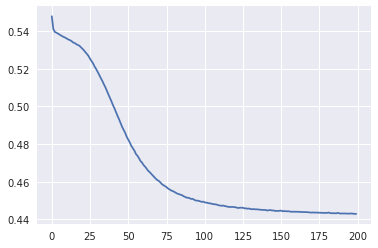

In [163]:
plt.plot(history.history['loss'])

/home/sheldonai/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


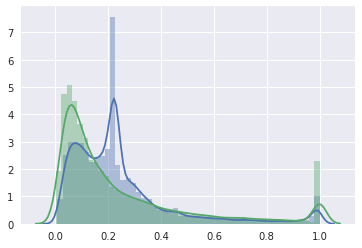

In [166]:
sns.distplot(model.predict(X))
sns.distplot(Y)

### Demo

In [180]:
STARTUP_TAGLINE = 'Interactive mystery and unannounced monthly deliveries'
text = word_tokenize(STARTUP_TAGLINE.lower())
record = []
for word in text:
    for i, vword in enumerate(vocab_list):
        if word == vword:
            record.append(i)
            break
x_eval = pad_sequences(np.array([record]), maxlen=seq_size)
print('"{}" will recieve {} points'.format(STARTUP_TAGLINE, 
                                           int(model.predict(x_eval)[0][0] * scores_limit)))

"Interactive mystery and unannounced monthly deliveries" will recieve 182 points
